In [4]:
#!/usr/bin/env python3
"""
Improved Hybrid CNN-LSTM + HuBERT Speech Emotion Recognition
Enhanced Version for Maximum Accuracy
"""

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from transformers import HubertForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import glob

# Enhanced Global Constants
HUBERT_MODEL = "superb/hubert-base-superb-er"
USE_FP16 = True
BATCH_SIZE = 16  # Increased from 8
SAMPLE_RATE = 16000
MAX_AUDIO_LENGTH = 3
N_MFCC = 30  # Increased from 20
EMOTIONS = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5,
    'surprise': 6
}
EPOCHS = 30  # Increased from 15
LEARNING_RATE = 0.0005  # Increased slightly
FREEZE_HUBERT_LAYERS = 2  # Decreased from 4 (more trainable layers)
MAX_SAMPLES_PER_CLASS = 500  # Increased from 300


# Enhanced MFCC extraction with additional features
def extract_mfcc_with_deltas(y, sr=SAMPLE_RATE, normalize=True):
    """Extract enhanced MFCC features with delta and delta-delta"""
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)

    # Add energy as an additional feature
    energy = np.mean(librosa.feature.rms(y=y).reshape(-1))
    energy_feature = np.ones((1, mfccs.shape[1])) * energy

    # Calculate delta and delta-delta
    delta = librosa.feature.delta(mfccs)
    delta2 = librosa.feature.delta(mfccs, order=2)

    # Add spectral contrast features
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

    # Add zero-crossing rate
    zcr = librosa.feature.zero_crossing_rate(y)

    # Add chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)

    # Combine all features
    mfccs = np.concatenate([mfccs, delta, delta2, energy_feature, contrast, zcr, chroma], axis=0)

    # Normalize features
    if normalize:
        scaler = StandardScaler()
        mfccs = scaler.fit_transform(mfccs)

    # Ensure fixed width (time dimension)
    target_width = 100
    if mfccs.shape[1] > target_width:
        mfccs = mfccs[:, :target_width]
    else:
        pad_width = target_width - mfccs.shape[1]
        mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')

    return mfccs


# Enhanced data augmentation
def augment_audio(y, sr):
    """Apply enhanced random augmentation to audio"""
    original_len = len(y)

    # Random pitch shift
    if np.random.rand() < 0.5:
        n_steps = np.random.randint(-3, 4)  # Wider range
        y = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps)

    # Add noise with varying intensity
    if np.random.rand() < 0.4:  # Increased probability
        noise_factor = np.random.uniform(0.001, 0.01)  # Varying noise levels
        noise = np.random.normal(0, noise_factor, len(y))
        y = y + noise

    # Time stretching (speed up/slow down without changing pitch)
    if np.random.rand() < 0.3:
        stretch_factor = np.random.uniform(0.85, 1.15)  # 15% slower or faster
        y = librosa.effects.time_stretch(y, rate=stretch_factor)

    # Add reverb effect
    if np.random.rand() < 0.2:
        reverb_delay = np.random.randint(50, 200)
        y_shifted = np.zeros_like(y)
        y_shifted[reverb_delay:] = y[:-reverb_delay] if reverb_delay < len(y) else y
        reverb_factor = np.random.uniform(0.1, 0.3)
        y = y + reverb_factor * y_shifted

    # Time masking (mask random segments of audio)
    if np.random.rand() < 0.2:
        n_masks = np.random.randint(1, 3)
        for _ in range(n_masks):
            mask_length = np.random.randint(sr * 0.05, sr * 0.15)  # 5-15% of a second
            mask_start = np.random.randint(0, len(y) - mask_length)
            y[mask_start:mask_start + mask_length] = 0

    # Ensure same length as original
    if len(y) != original_len:
        if len(y) > original_len:
            y = y[:original_len]
        else:
            y = np.pad(y, (0, original_len - len(y)))

    return y


# Enhanced CNN-LSTM pathway
class CNN_LSTM(nn.Module):
    def __init__(self, input_height=None, input_width=100, hidden_size=128):  # Increased hidden size
        super(CNN_LSTM, self).__init__()

        # Calculate input height based on feature extraction
        if input_height is None:
            # Estimate based on MFCCs, deltas, energy, contrast, ZCR, and chroma
            input_height = N_MFCC * 3 + 1 + 7 + 1 + 12  # Approximation

        self.input_height = input_height
        self.input_width = input_width

        # Enhanced CNN layers
        self.cnn = nn.Sequential(
            # First conv block
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # More filters (16->32)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # More filters (32->64)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            # Third conv block (new)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )

        # Calculate CNN output dimensions
        with torch.no_grad():
            dummy = torch.zeros(1, 1, self.input_height, self.input_width)
            cnn_out = self.cnn(dummy)
            _, c, h, w = cnn_out.shape
            self.lstm_input_size = c * h

        # Enhanced LSTM layer
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=hidden_size,
            num_layers=2,  # Increased from 1 to 2 layers
            batch_first=True,
            bidirectional=True,
            dropout=0.2  # Add dropout between LSTM layers
        )

        # Output size will be 2*hidden_size due to bidirectional LSTM
        self.output_dim = hidden_size * 2

    def forward(self, x):
        # Add channel dimension [batch, height, width] -> [batch, 1, height, width]
        x = x.unsqueeze(1)

        # Pass through CNN
        x = self.cnn(x)

        # Reshape for LSTM: [batch, channels, height, width] -> [batch, width, channels*height]
        batch_size, c, h, w = x.size()
        x = x.permute(0, 3, 1, 2).reshape(batch_size, w, c * h)

        # Pass through LSTM and get final output
        x, _ = self.lstm(x)
        # Use attention-like pooling: consider all time steps, not just the last one
        x = torch.mean(x, dim=1)

        return x


# Improved HuBERT pathway
class HuBERTModule(nn.Module):
    def __init__(self, pretrained_model=HUBERT_MODEL):
        super(HuBERTModule, self).__init__()

        # Load pre-trained HuBERT model
        self.hubert = HubertForSequenceClassification.from_pretrained(pretrained_model)

        # Freeze feature extractor and some of the encoder layers
        self._freeze_base_layers()

        # Add additional processing for HuBERT output
        self.output_processor = nn.Sequential(
            nn.Linear(self.hubert.config.hidden_size, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 256)
        )

        # Output dimension is now fixed at 256
        self.output_dim = 256

    def _freeze_base_layers(self):
        # Freeze feature extractor (always frozen)
        for param in self.hubert.hubert.feature_extractor.parameters():
            param.requires_grad = False

        # Freeze some encoder layers
        for i, layer in enumerate(self.hubert.hubert.encoder.layers):
            if i < FREEZE_HUBERT_LAYERS:
                for param in layer.parameters():
                    param.requires_grad = False

    def forward(self, x):
        # Use mixed precision where available
        with torch.cuda.amp.autocast(enabled=USE_FP16):
            outputs = self.hubert.hubert(x)
            # Use mean pooling of the last hidden states
            pooled_output = torch.mean(outputs.last_hidden_state, dim=1)
            # Apply additional processing
            processed_output = self.output_processor(pooled_output)

        return processed_output


# Focal Loss for better handling of class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


# Improved Hybrid Model with Attention
class HybridModel(nn.Module):
    def __init__(self, num_emotions=len(EMOTIONS)):
        super(HybridModel, self).__init__()

        # Initialize the two pathways
        self.cnn_lstm = CNN_LSTM()
        self.hubert = HuBERTModule()

        # Determine the output dimensions of each pathway
        self.cnn_lstm_dim = self.cnn_lstm.output_dim
        self.hubert_dim = self.hubert.output_dim

        # Improved fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(self.cnn_lstm_dim + self.hubert_dim, 256),  # Larger first layer
            nn.BatchNorm1d(256),  # Add batch norm
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),  # Add another layer
            nn.BatchNorm1d(128),  # Add batch norm
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64)  # Final fusion dimension
        )

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

        # Classifier layer
        self.classifier = nn.Linear(64, num_emotions)

    def forward(self, mfcc, audio):
        # Process through CNN-LSTM pathway
        cnn_lstm_out = self.cnn_lstm(mfcc)

        # Process through HuBERT pathway
        hubert_out = self.hubert(audio)

        # Concatenate outputs
        combined = torch.cat((cnn_lstm_out, hubert_out), dim=1)

        # Apply fusion layer
        fused = self.fusion(combined)

        # Apply attention (optional - can be disabled)
        attention_weights = torch.softmax(self.attention(fused), dim=1)
        attended_fused = fused * attention_weights

        # Final classification
        output = self.classifier(attended_fused)

        return output


# Enhanced Dataset class for emotion data
class EmotionDataset(Dataset):
    def __init__(self, mfccs, audio, labels, augment=True):
        self.mfccs = mfccs
        self.audio = audio
        self.labels = labels
        self.augment = augment

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        mfcc = torch.tensor(self.mfccs[idx], dtype=torch.float32)
        audio = self.audio[idx].copy()
        label = self.labels[idx]

        # Apply augmentation during training with higher probability
        if self.augment and np.random.rand() < 0.7:  # Increased from 0.5
            audio = augment_audio(audio, SAMPLE_RATE)

        audio = torch.tensor(audio, dtype=torch.float32)

        return mfcc, audio, label


def load_ravdess_data(data_path):
    """Load RAVDESS dataset"""
    files = []
    emotions = []

    # Find all WAV files
    for actor_dir in glob.glob(os.path.join(data_path, "*")):
        if not os.path.isdir(actor_dir):
            continue

        for file in glob.glob(os.path.join(actor_dir, "*.wav")):
            filename = os.path.basename(file)
            parts = filename.split("-")

            # Extract emotion code from filename
            if len(parts) >= 3:
                emotion_code = int(parts[2])
                emotion_map = {
                    1: 'neutral',
                    3: 'happy',
                    4: 'sad',
                    5: 'angry',
                    6: 'fear',
                    7: 'disgust',
                    8: 'surprise'
                }

                # Map emotion code to our emotion categories
                emotion = emotion_map.get(emotion_code)
                if emotion in EMOTIONS:
                    files.append(file)
                    emotions.append(EMOTIONS[emotion])

    # Create DataFrame
    df = pd.DataFrame({"file": files, "emotion": emotions})

    # Print dataset statistics
    print("Dataset statistics:")
    for emotion, count in df["emotion"].value_counts().items():
        emotion_name = list(EMOTIONS.keys())[list(EMOTIONS.values()).index(emotion)]
        print(f"  {emotion_name}: {count} samples")

    return df


def prepare_dataset(data_df, max_samples_per_class=MAX_SAMPLES_PER_CLASS):
    """Extract features from audio files and prepare dataset"""
    X_mfcc = []
    X_audio = []
    y = []

    # Balance dataset if requested
    if max_samples_per_class:
        balanced_df = pd.DataFrame()
        for emotion_name, emotion_idx in EMOTIONS.items():
            emotion_df = data_df[data_df['emotion'] == emotion_idx]

            # If we have fewer samples than requested, use data augmentation to create more
            if len(emotion_df) < max_samples_per_class:
                print(f"  Note: Augmenting {emotion_name} class which has only {len(emotion_df)} samples")
                # Use what we have and we'll augment them later
            elif len(emotion_df) > max_samples_per_class:
                emotion_df = emotion_df.sample(max_samples_per_class, random_state=42)

            balanced_df = pd.concat([balanced_df, emotion_df], ignore_index=True)
        data_df = balanced_df

    # Process each file
    print("Processing audio files...")
    total_files = len(data_df)

    for i, (_, row) in enumerate(data_df.iterrows()):
        if i % 100 == 0:
            print(f"  Progress: {i}/{total_files} files processed")

        file_path = row["file"]
        emotion = row["emotion"]

        try:
            # Load audio file
            audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=MAX_AUDIO_LENGTH)

            # Ensure fixed length
            if len(audio) < SAMPLE_RATE * MAX_AUDIO_LENGTH:
                audio = np.pad(audio, (0, int(SAMPLE_RATE * MAX_AUDIO_LENGTH) - len(audio)))
            else:
                audio = audio[:int(SAMPLE_RATE * MAX_AUDIO_LENGTH)]

            # Extract MFCC features
            mfcc = extract_mfcc_with_deltas(audio, sr)

            X_mfcc.append(mfcc)
            X_audio.append(audio)
            y.append(emotion)

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    # Convert lists to arrays
    X_mfcc = np.array(X_mfcc)
    X_audio = np.array(X_audio)
    y = np.array(y)

    # Split into train, validation, and test sets
    # Use stratified splitting to maintain class distribution
    train_idx, test_idx, y_train_temp, y_test = train_test_split(
        np.arange(len(y)), y, test_size=0.2, random_state=42, stratify=y
    )

    # Further split training data into train and validation
    train_idx, val_idx, y_train, y_val = train_test_split(
        train_idx, y[train_idx], test_size=0.25, random_state=42, stratify=y[train_idx]
    )

    # Extract the corresponding data for each split
    X_mfcc_train = X_mfcc[train_idx]
    X_mfcc_val = X_mfcc[val_idx]
    X_mfcc_test = X_mfcc[test_idx]

    X_audio_train = X_audio[train_idx]
    X_audio_val = X_audio[val_idx]
    X_audio_test = X_audio[test_idx]

    return X_mfcc_train, X_mfcc_val, X_mfcc_test, X_audio_train, X_audio_val, X_audio_test, y_train, y_val, y_test


def create_dataloaders(X_mfcc_train, X_mfcc_val, X_mfcc_test, X_audio_train, X_audio_val, X_audio_test, y_train, y_val, y_test):
    """Create PyTorch DataLoaders"""
    # Create datasets
    train_dataset = EmotionDataset(X_mfcc_train, X_audio_train, y_train, augment=True)
    val_dataset = EmotionDataset(X_mfcc_val, X_audio_val, y_val, augment=False)
    test_dataset = EmotionDataset(X_mfcc_test, X_audio_test, y_test, augment=False)

    # Create dataloaders with appropriate batch sizes
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader


def clear_gpu_memory():
    """Clear CUDA cache and trigger garbage collection"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()


def train_model(model, train_loader, val_loader, epochs=EPOCHS, learning_rate=LEARNING_RATE):
    """Train the hybrid model with improved optimization"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Calculate class weights for handling imbalanced classes
    # (Only needed if there's a significant class imbalance)
    # class_weights = torch.tensor([1.0, 1.0, 1.0, 1.5, 1.3, 1.0, 1.0], device=device)

    # Loss function - Focal Loss for better handling of class imbalance
    # criterion = FocalLoss(gamma=2.0)
    criterion = nn.CrossEntropyLoss()  # Standard cross-entropy, works well for balanced datasets

    # Improved optimizer with different learning rates for different components
    optimizer = optim.AdamW([
        {'params': model.cnn_lstm.parameters(), 'lr': learning_rate},
        {'params': model.hubert.parameters(), 'lr': learning_rate / 10},  # Lower LR for pre-trained model
        {'params': model.fusion.parameters(), 'lr': learning_rate * 1.5},  # Higher LR for fusion
        {'params': model.classifier.parameters(), 'lr': learning_rate * 2}  # Even higher for classifier
    ], weight_decay=0.01, betas=(0.9, 0.999))

    # Improved learning rate scheduler - OneCycleLR
    one_cycle_scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=[learning_rate*2, learning_rate/5, learning_rate*3, learning_rate*4],
        epochs=epochs, steps_per_epoch=len(train_loader), pct_start=0.3,
        div_factor=10, final_div_factor=100
    )

    # Mixed precision for faster training
    scaler = torch.cuda.amp.GradScaler(enabled=USE_FP16)

    # For tracking metrics
    best_val_acc = 0.0
    no_improvement_count = 0
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        # Training step
        for batch_mfcc, batch_audio, batch_labels in train_loader:
            batch_mfcc = batch_mfcc.to(device)
            batch_audio = batch_audio.to(device)
            batch_labels = batch_labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass with mixed precision
            with torch.cuda.amp.autocast(enabled=USE_FP16):
                outputs = model(batch_mfcc, batch_audio)
                loss = criterion(outputs, batch_labels)

            # Backward pass with scaling
            scaler.scale(loss).backward()

            # Apply gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update weights
            scaler.step(optimizer)
            scaler.update()

            # Update learning rate
            one_cycle_scheduler.step()

            # Track metrics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_labels.size(0)
            train_correct += (predicted == batch_labels).sum().item()

            # Free up memory
            del batch_mfcc, batch_audio, batch_labels, outputs

        train_loss /= len(train_loader)
        train_accuracy = train_correct / train_total if train_total > 0 else 0
        train_losses.append(train_loss)

        # Validation step
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch_mfcc, batch_audio, batch_labels in val_loader:
                batch_mfcc = batch_mfcc.to(device)
                batch_audio = batch_audio.to(device)
                batch_labels = batch_labels.to(device)

                # Forward pass
                outputs = model(batch_mfcc, batch_audio)
                loss = criterion(outputs, batch_labels)

                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()

                # Free up memory
                del batch_mfcc, batch_audio, batch_labels, outputs

            # Clear cache
            clear_gpu_memory()

        val_loss /= len(val_loader)
        val_accuracy = correct / total if total > 0 else 0

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print progress
        print(f'Epoch {epoch+1}/{epochs}, '
              f'Train Loss: {train_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Accuracy: {val_accuracy:.4f}')

        # Save best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            no_improvement_count = 0
            print(f"  New best model saved with validation accuracy: {val_accuracy:.4f}")
        else:
            no_improvement_count += 1

        # Early stopping with patience
        if no_improvement_count >= 8:  # Increased from 5 for more chances
            print("Early stopping triggered after 8 epochs without improvement")
            break

    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))

    return model, train_losses, val_losses, val_accuracies


def evaluate_model(model, test_loader):
    """Evaluate model on test set"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch_mfcc, batch_audio, batch_labels in test_loader:
            batch_mfcc = batch_mfcc.to(device)
            batch_audio = batch_audio.to(device)

            # Forward pass
            outputs = model(batch_mfcc, batch_audio)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.numpy())
            all_probs.extend(probabilities.cpu().numpy())

            # Free up memory
            del batch_mfcc, batch_audio, outputs, predicted

    # Map indices to emotion names
    idx_to_emotion = {v: k for k, v in EMOTIONS.items()}
    present_classes = sorted(set(all_labels))
    class_names = [idx_to_emotion[i] for i in present_classes]

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    class_report = classification_report(
        all_labels, all_preds,
        target_names=class_names,
        labels=present_classes
    )
    cm = confusion_matrix(all_labels, all_preds)

    # Print results
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.close()

    # Plot probabilities distribution (optional)
    plt.figure(figsize=(12, 8))
    all_probs = np.array(all_probs)
    for i, emotion in enumerate(class_names):
        # Get samples that belong to this class
        class_indices = [j for j, label in enumerate(all_labels) if label == present_classes[i]]
        if class_indices:
            # Get their probability for the correct class
            correct_probs = [all_probs[j][present_classes[i]] for j in class_indices]
            sns.kdeplot(correct_probs, label=f"{emotion} (n={len(class_indices)})")

    plt.xlabel('Probability of Correct Class')
    plt.ylabel('Density')
    plt.title('Distribution of Prediction Confidence by Emotion')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('prediction_confidence.png')
    plt.close()

    return accuracy, class_report, cm


def plot_training_history(train_losses, val_losses, val_accuracies):
    """Plot enhanced training history"""
    plt.figure(figsize=(15, 10))

    # Plot losses
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Training Loss', color='#1f77b4', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', color='#ff7f0e', linewidth=2)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot accuracy
    plt.subplot(2, 1, 2)
    plt.plot(val_accuracies, label='Validation Accuracy', color='#2ca02c', linewidth=2)
    # Add threshold lines
    plt.axhline(y=0.7, color='r', linestyle='--', alpha=0.3, label='70% Threshold')
    plt.axhline(y=0.8, color='g', linestyle='--', alpha=0.3, label='80% Threshold')
    plt.axhline(y=0.9, color='b', linestyle='--', alpha=0.3, label='90% Threshold')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()


def train_ensemble(train_loader, val_loader, n_models=3):
    """Train multiple models and use voting for predictions"""
    models = []

    for i in range(n_models):
        print(f"\nTraining model {i+1}/{n_models} for ensemble")
        model = HybridModel()
        model, _, _, _ = train_model(model, train_loader, val_loader, epochs=EPOCHS)
        models.append(model)

        # Save ensemble model
        torch.save(model.state_dict(), f'ensemble_model_{i+1}.pth')

        # Clear GPU memory between model training
        clear_gpu_memory()

    return models


def ensemble_predict(models, test_loader):
    """Get predictions from multiple models using majority voting"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_preds = []
    all_probs = []
    all_labels = []  # Initialize as empty list instead of None

    for i, model in enumerate(models):
        print(f"Getting predictions from ensemble model {i+1}/{len(models)}")
        model.to(device)
        model.eval()
        model_preds = []
        model_probs = []

        # For the first model, we'll also collect labels
        collect_labels = (i == 0)

        with torch.no_grad():
            for batch_mfcc, batch_audio, batch_labels in test_loader:
                batch_mfcc = batch_mfcc.to(device)
                batch_audio = batch_audio.to(device)

                outputs = model(batch_mfcc, batch_audio)
                probabilities = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs.data, 1)

                model_preds.extend(predicted.cpu().numpy())
                model_probs.append(probabilities.cpu().numpy())

                # Only collect labels with the first model
                if collect_labels:
                    all_labels.extend(batch_labels.numpy())

                # Free up memory
                del batch_mfcc, batch_audio, outputs, predicted

            # Clear cache
            clear_gpu_memory()

        all_preds.append(model_preds)

        # Convert list of arrays to a single array and store
        if model_probs:  # Check if list is not empty
            model_probs = np.vstack(model_probs)
            all_probs.append(model_probs)

    # Transpose to get predictions per sample
    all_preds = np.array(all_preds)

    # Handle the case where all_probs might be empty
    if all_probs:
        all_probs = np.array(all_probs)

        # Two methods for ensemble:
        # 1. Hard voting (majority vote)
        final_preds_hard = []
        for i in range(all_preds.shape[1]):
            # Count votes for each class
            pred = np.bincount(all_preds[:, i]).argmax()
            final_preds_hard.append(pred)

        # 2. Soft voting (average probabilities)
        avg_probs = np.mean(all_probs, axis=0)
        final_preds_soft = np.argmax(avg_probs, axis=1)
    else:
        # Fallback if no probabilities were collected
        final_preds_hard = []
        for i in range(all_preds.shape[1]):
            pred = np.bincount(all_preds[:, i]).argmax()
            final_preds_hard.append(pred)
        final_preds_soft = np.array(final_preds_hard)  # Just use hard predictions

    return np.array(final_preds_hard), np.array(final_preds_soft), np.array(all_labels)


def download_dataset():
    """Download RAVDESS dataset using kagglehub if possible"""
    try:
        import kagglehub
        print("Downloading RAVDESS dataset...")
        dataset_path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
        print(f"Dataset downloaded to {dataset_path}")
        return dataset_path
    except Exception as e:
        print(f"Failed to download dataset: {e}")
        print("Please manually provide the dataset path.")
        return None


def main():
    """Main function to run the improved speech emotion recognition pipeline"""
    print("Speech Emotion Recognition with Improved Hybrid CNN-LSTM + HuBERT\n")

    # Check for GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Try to download dataset or use provided path
    data_path = download_dataset()
    if not data_path:
        print("Enter the path to the RAVDESS dataset:")
        data_path = input("Path: ").strip()

    # Load data
    print("\n1. Loading data...")
    data_df = load_ravdess_data(data_path)
    print(f"Found {len(data_df)} audio files")

    # Prepare dataset
    print("\n2. Extracting features...")
    X_mfcc_train, X_mfcc_val, X_mfcc_test, X_audio_train, X_audio_val, X_audio_test, y_train, y_val, y_test = prepare_dataset(
        data_df, max_samples_per_class=MAX_SAMPLES_PER_CLASS
    )

    print(f"Training set: {len(X_mfcc_train)} samples")
    print(f"Validation set: {len(X_mfcc_val)} samples")
    print(f"Test set: {len(X_mfcc_test)} samples")

    # Create DataLoaders
    print("\n3. Creating DataLoaders...")
    train_loader, val_loader, test_loader = create_dataloaders(
        X_mfcc_train, X_mfcc_val, X_mfcc_test,
        X_audio_train, X_audio_val, X_audio_test,
        y_train, y_val, y_test
    )

    # Initialize model
    print("\n4. Initializing model...")
    model = HybridModel()

    # Count trainable parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Percentage trainable: {100 * trainable_params / total_params:.2f}%")

    # Ask if user wants to use ensemble
    use_ensemble = False
    try:
        choice = input("\nUse ensemble of multiple models for better accuracy? (y/n, default=n): ").strip().lower()
        use_ensemble = choice == 'y'
    except:
        pass

    if use_ensemble:
        # Train ensemble
        print("\n5. Training ensemble of models...")
        n_models = 3  # Default to 3 models in ensemble
        models = train_ensemble(train_loader, val_loader, n_models=n_models)

        # Evaluate ensemble
        print("\n6. Evaluating ensemble...")
        final_preds_hard, final_preds_soft, test_labels = ensemble_predict(models, test_loader)

        # Calculate and print metrics for hard voting
        accuracy_hard = accuracy_score(test_labels, final_preds_hard)
        print(f"\nEnsemble Accuracy (Hard Voting): {accuracy_hard:.4f}")

        # Calculate and print metrics for soft voting
        accuracy_soft = accuracy_score(test_labels, final_preds_soft)
        print(f"Ensemble Accuracy (Soft Voting): {accuracy_soft:.4f}")

        # Use best method for final metrics
        if accuracy_soft > accuracy_hard:
            print("Using soft voting for final results (better performance)")
            final_preds = final_preds_soft
        else:
            print("Using hard voting for final results (better performance)")
            final_preds = final_preds_hard

        # Map indices to emotion names
        idx_to_emotion = {v: k for k, v in EMOTIONS.items()}
        present_classes = sorted(set(test_labels))
        class_names = [idx_to_emotion[i] for i in present_classes]

        # Classification report and confusion matrix
        class_report = classification_report(
            test_labels, final_preds,
            target_names=class_names,
            labels=present_classes
        )
        cm = confusion_matrix(test_labels, final_preds)

        print("\nEnsemble Classification Report:")
        print(class_report)

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Ensemble Confusion Matrix')
        plt.savefig('ensemble_confusion_matrix.png')
        plt.close()

        # Save ensemble models info
        torch.save({
            'accuracy': max(accuracy_hard, accuracy_soft),
            'emotions': EMOTIONS,
            'ensemble_size': n_models
        }, 'ensemble_model_info.pth')
    else:
        # Train single model
        print("\n5. Training model...")
        model, train_losses, val_losses, val_accuracies = train_model(
            model, train_loader, val_loader, epochs=EPOCHS
        )

        # Plot training history
        print("\n6. Plotting training history...")
        plot_training_history(train_losses, val_losses, val_accuracies)

        # Evaluate model
        print("\n7. Evaluating model...")
        accuracy, class_report, cm = evaluate_model(model, test_loader)

        # Save model
        print("\n8. Saving model...")
        torch.save({
            'model_state_dict': model.state_dict(),
            'accuracy': accuracy,
            'emotions': EMOTIONS,
        }, 'speech_emotion_model.pth')

    print("\nTraining and evaluation complete!")


if __name__ == "__main__":
    main()

Speech Emotion Recognition with Improved Hybrid CNN-LSTM + HuBERT

Using device: cuda
Dataset downloaded to /kaggle/input/ravdess-emotional-speech-audio

1. Loading data...
Dataset statistics:
  surprise: 192 samples
  disgust: 192 samples
  fear: 192 samples
  happy: 192 samples
  sad: 192 samples
  angry: 192 samples
  neutral: 96 samples
Found 1248 audio files

2. Extracting features...
  Note: Augmenting angry class which has only 192 samples
  Note: Augmenting disgust class which has only 192 samples
  Note: Augmenting fear class which has only 192 samples
  Note: Augmenting happy class which has only 192 samples
  Note: Augmenting neutral class which has only 96 samples
  Note: Augmenting sad class which has only 192 samples
  Note: Augmenting surprise class which has only 192 samples
Processing audio files...
  Progress: 0/1248 files processed
  Progress: 100/1248 files processed
  Progress: 200/1248 files processed
  Progress: 300/1248 files processed
  Progress: 400/1248 files

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Total parameters: 97,334,041
Trainable parameters: 78,957,849
Percentage trainable: 81.12%

Use ensemble of multiple models for better accuracy? (y/n, default=n): y

5. Training ensemble of models...

Training model 1/3 for ensemble


<ipython-input-4-602c8702114a>:540: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_FP16)
<ipython-input-4-602c8702114a>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_FP16):
<ipython-input-4-602c8702114a>:247: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_FP16):


Epoch 1/30, Train Loss: 1.9888, Train Accuracy: 0.1390, Val Loss: 1.9348, Val Accuracy: 0.1880
  New best model saved with validation accuracy: 0.1880
Epoch 2/30, Train Loss: 1.9047, Train Accuracy: 0.2099, Val Loss: 1.8622, Val Accuracy: 0.3280
  New best model saved with validation accuracy: 0.3280
Epoch 3/30, Train Loss: 1.8204, Train Accuracy: 0.2540, Val Loss: 1.6787, Val Accuracy: 0.3720
  New best model saved with validation accuracy: 0.3720
Epoch 4/30, Train Loss: 1.6527, Train Accuracy: 0.3489, Val Loss: 1.3536, Val Accuracy: 0.4880
  New best model saved with validation accuracy: 0.4880
Epoch 5/30, Train Loss: 1.5145, Train Accuracy: 0.4184, Val Loss: 1.0787, Val Accuracy: 0.6080
  New best model saved with validation accuracy: 0.6080
Epoch 6/30, Train Loss: 1.3765, Train Accuracy: 0.4786, Val Loss: 0.9930, Val Accuracy: 0.6160
  New best model saved with validation accuracy: 0.6160
Epoch 7/30, Train Loss: 1.2818, Train Accuracy: 0.5414, Val Loss: 1.0356, Val Accuracy: 0.6160

Speech Emotion Recognition - Prediction Tool
This script uses a trained Hybrid CNN-LSTM + HuBERT model to predict emotions from audio files.
Compatible with both single model and ensemble model configurations.

Using device: cuda
Found ensemble model info at: ./ensemble_model_info.pth
Found ensemble model 1 at: ./ensemble_model_1.pth
Found ensemble model 2 at: ./ensemble_model_2.pth
Found ensemble model 3 at: ./ensemble_model_3.pth

Using ensemble of 3 models for prediction.
Successfully loaded ensemble model from ./ensemble_model_1.pth
Successfully loaded ensemble model from ./ensemble_model_2.pth
Successfully loaded ensemble model from ./ensemble_model_3.pth

Now upload an audio file (WAV, MP3, OGG, etc.) to analyze:


Saving 03-01-07-01-01-02-19.wav to 03-01-07-01-01-02-19.wav

Processing 03-01-07-01-01-02-19.wav...

Playing audio:


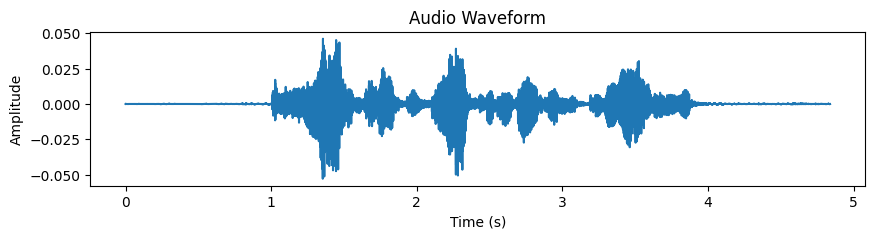


Predicting emotion...
Ensemble prediction:
  Hard voting: 🤢 DISGUST
  Soft voting: 🤢 DISGUST (selected)

Predicted emotion: 🤢 DISGUST (99.57% confidence)

All emotion probabilities:
  🤢 disgust : 99.57%
  😠 angry   : 0.33%
  😢 sad     : 0.05%
  😲 surprise: 0.03%
  😨 fear    : 0.01%
  😐 neutral : 0.00%
  😃 happy   : 0.00%


<ipython-input-5-e00189a08e5a>:227: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_FP16):
<ipython-input-5-e00189a08e5a>:611: UserWarning: Glyph 129314 (\N{NAUSEATED FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-5-e00189a08e5a>:612: UserWarning: Glyph 129314 (\N{NAUSEATED FACE}) missing from font(s) DejaVu Sans.
  plt.savefig('emotion_prediction.png')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129314 (\N{NAUSEATED FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


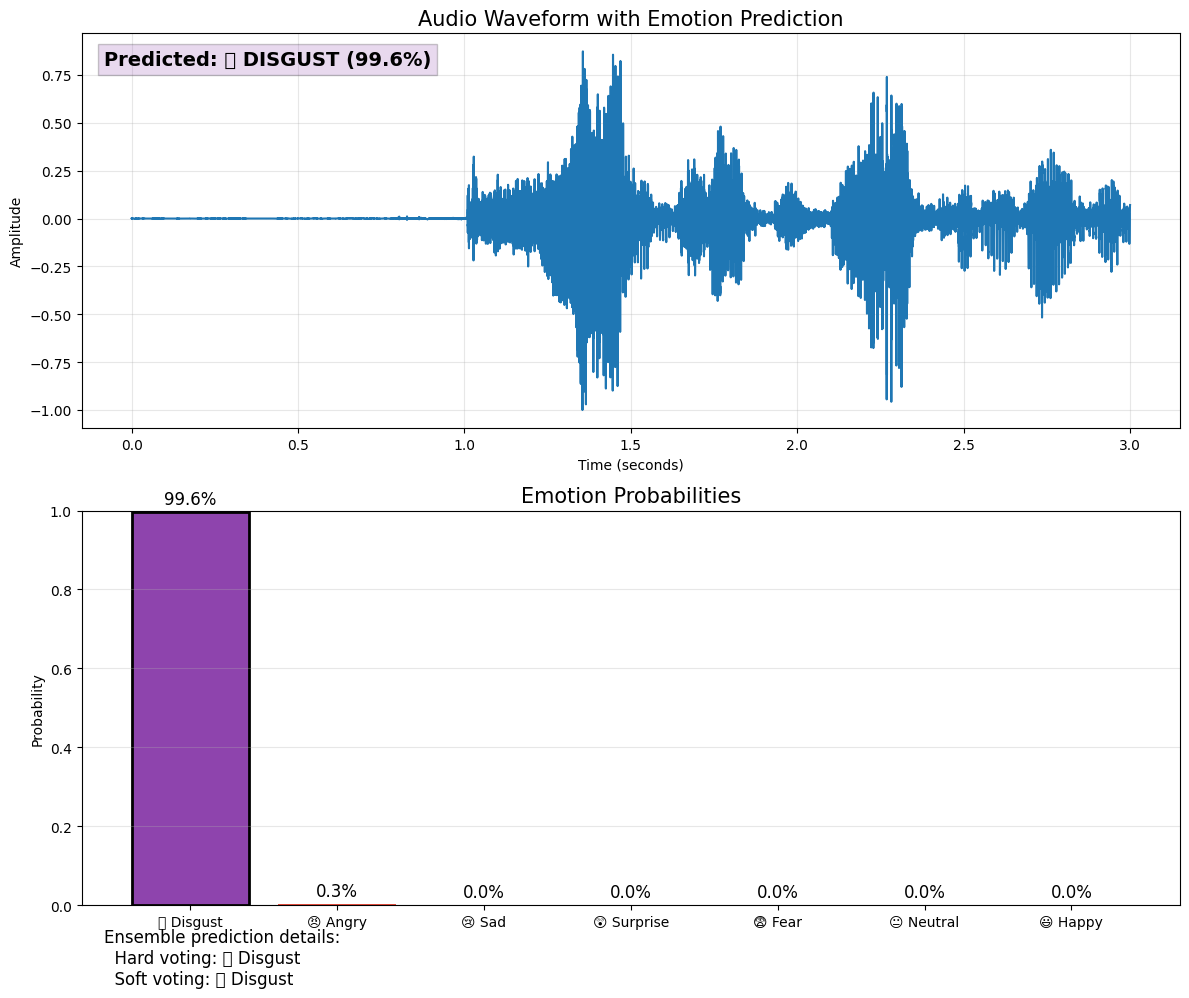

In [5]:
#!/usr/bin/env python3
"""
Speech Emotion Recognition - Prediction Script (Colab-compatible)
Uses the saved model to predict emotions from audio files
Modified to work with the Improved Hybrid CNN-LSTM + HuBERT model
"""

import os
import torch
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from google.colab import files
import IPython.display as ipd
from sklearn.preprocessing import StandardScaler
import gc

# Global Constants - match the training script
HUBERT_MODEL = "superb/hubert-base-superb-er"
USE_FP16 = True
BATCH_SIZE = 16
SAMPLE_RATE = 16000
MAX_AUDIO_LENGTH = 3  # in seconds
N_MFCC = 30  # Increased from 20 to match training
EMOTIONS = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5,
    'surprise': 6
}
FREEZE_HUBERT_LAYERS = 2  # Match with training script

# Model paths - check both current directory and common paths
MODEL_FILE = 'speech_emotion_model.pth'
ENSEMBLE_MODEL_PREFIX = 'ensemble_model_'
ENSEMBLE_INFO_FILE = 'ensemble_model_info.pth'
POTENTIAL_PATHS = [
    './',
    '/content/',
    '/content/drive/MyDrive/',
    '/content/drive/MyDrive/emotion_data/',
]

# Emotion colors and icons for visualization
EMOTION_COLORS = {
    'angry': '#E74C3C',     # Red
    'disgust': '#8E44AD',   # Purple
    'fear': '#5499C7',      # Blue
    'happy': '#F1C40F',     # Yellow
    'neutral': '#95A5A6',   # Gray
    'sad': '#3498DB',       # Light Blue
    'surprise': '#2ECC71'   # Green
}

EMOTION_EMOJIS = {
    'angry': '😠',
    'disgust': '🤢',
    'fear': '😨',
    'happy': '😃',
    'neutral': '😐',
    'sad': '😢',
    'surprise': '😲'
}


# Enhanced MFCC extraction to match training function
def extract_mfcc_with_deltas(y, sr=SAMPLE_RATE, normalize=True):
    """Extract enhanced MFCC features with delta and delta-delta"""
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)

    # Add energy as an additional feature
    energy = np.mean(librosa.feature.rms(y=y).reshape(-1))
    energy_feature = np.ones((1, mfccs.shape[1])) * energy

    # Calculate delta and delta-delta
    delta = librosa.feature.delta(mfccs)
    delta2 = librosa.feature.delta(mfccs, order=2)

    # Add spectral contrast features
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

    # Add zero-crossing rate
    zcr = librosa.feature.zero_crossing_rate(y)

    # Add chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)

    # Combine all features
    mfccs = np.concatenate([mfccs, delta, delta2, energy_feature, contrast, zcr, chroma], axis=0)

    # Normalize features
    if normalize:
        scaler = StandardScaler()
        mfccs = scaler.fit_transform(mfccs)

    # Ensure fixed width (time dimension)
    target_width = 100
    if mfccs.shape[1] > target_width:
        mfccs = mfccs[:, :target_width]
    else:
        pad_width = target_width - mfccs.shape[1]
        mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')

    return mfccs


# Enhanced CNN-LSTM pathway
class CNN_LSTM(torch.nn.Module):
    def __init__(self, input_height=None, input_width=100, hidden_size=128):  # Increased hidden size
        super(CNN_LSTM, self).__init__()

        # Calculate input height based on feature extraction
        if input_height is None:
            # Estimate based on MFCCs, deltas, energy, contrast, ZCR, and chroma
            input_height = N_MFCC * 3 + 1 + 7 + 1 + 12  # Approximation

        self.input_height = input_height
        self.input_width = input_width

        # Enhanced CNN layers
        self.cnn = torch.nn.Sequential(
            # First conv block
            torch.nn.Conv2d(1, 32, kernel_size=3, padding=1),  # More filters (16->32)
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout(0.3),

            # Second conv block
            torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),  # More filters (32->64)
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout(0.3),

            # Third conv block (new)
            torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout(0.3)
        )

        # Calculate CNN output dimensions
        with torch.no_grad():
            dummy = torch.zeros(1, 1, self.input_height, self.input_width)
            cnn_out = self.cnn(dummy)
            _, c, h, w = cnn_out.shape
            self.lstm_input_size = c * h

        # Enhanced LSTM layer
        self.lstm = torch.nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=hidden_size,
            num_layers=2,  # Increased from 1 to 2 layers
            batch_first=True,
            bidirectional=True,
            dropout=0.2  # Add dropout between LSTM layers
        )

        # Output size will be 2*hidden_size due to bidirectional LSTM
        self.output_dim = hidden_size * 2

    def forward(self, x):
        # Add channel dimension [batch, height, width] -> [batch, 1, height, width]
        x = x.unsqueeze(1)

        # Pass through CNN
        x = self.cnn(x)

        # Reshape for LSTM: [batch, channels, height, width] -> [batch, width, channels*height]
        batch_size, c, h, w = x.size()
        x = x.permute(0, 3, 1, 2).reshape(batch_size, w, c * h)

        # Pass through LSTM and get final output
        x, _ = self.lstm(x)
        # Use attention-like pooling: consider all time steps, not just the last one
        x = torch.mean(x, dim=1)

        return x


# Improved HuBERT pathway
class HuBERTModule(torch.nn.Module):
    def __init__(self, pretrained_model=HUBERT_MODEL):
        super(HuBERTModule, self).__init__()

        # Import here to avoid loading if not needed
        from transformers import HubertForSequenceClassification

        # Load pre-trained HuBERT model
        self.hubert = HubertForSequenceClassification.from_pretrained(pretrained_model)

        # Freeze feature extractor and some of the encoder layers
        self._freeze_base_layers()

        # Add additional processing for HuBERT output
        self.output_processor = torch.nn.Sequential(
            torch.nn.Linear(self.hubert.config.hidden_size, 256),
            torch.nn.LayerNorm(256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(256, 256)
        )

        # Output dimension is now fixed at 256
        self.output_dim = 256

    def _freeze_base_layers(self):
        # Freeze feature extractor (always frozen)
        for param in self.hubert.hubert.feature_extractor.parameters():
            param.requires_grad = False

        # Freeze some encoder layers
        for i, layer in enumerate(self.hubert.hubert.encoder.layers):
            if i < FREEZE_HUBERT_LAYERS:
                for param in layer.parameters():
                    param.requires_grad = False

    def forward(self, x):
        # Use mixed precision where available
        with torch.cuda.amp.autocast(enabled=USE_FP16):
            outputs = self.hubert.hubert(x)
            # Use mean pooling of the last hidden states
            pooled_output = torch.mean(outputs.last_hidden_state, dim=1)
            # Apply additional processing
            processed_output = self.output_processor(pooled_output)

        return processed_output


# Improved Hybrid Model with Attention
class HybridModel(torch.nn.Module):
    def __init__(self, num_emotions=len(EMOTIONS)):
        super(HybridModel, self).__init__()

        # Initialize the two pathways
        self.cnn_lstm = CNN_LSTM()
        self.hubert = HuBERTModule()

        # Determine the output dimensions of each pathway
        self.cnn_lstm_dim = self.cnn_lstm.output_dim
        self.hubert_dim = self.hubert.output_dim

        # Improved fusion layer
        self.fusion = torch.nn.Sequential(
            torch.nn.Linear(self.cnn_lstm_dim + self.hubert_dim, 256),  # Larger first layer
            torch.nn.BatchNorm1d(256),  # Add batch norm
            torch.nn.ReLU(),
            torch.nn.Dropout(0.4),
            torch.nn.Linear(256, 128),  # Add another layer
            torch.nn.BatchNorm1d(128),  # Add batch norm
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(128, 64)  # Final fusion dimension
        )

        # Attention mechanism
        self.attention = torch.nn.Sequential(
            torch.nn.Linear(64, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 1)
        )

        # Classifier layer
        self.classifier = torch.nn.Linear(64, num_emotions)

    def forward(self, mfcc, audio):
        # Process through CNN-LSTM pathway
        cnn_lstm_out = self.cnn_lstm(mfcc)

        # Process through HuBERT pathway
        hubert_out = self.hubert(audio)

        # Concatenate outputs
        combined = torch.cat((cnn_lstm_out, hubert_out), dim=1)

        # Apply fusion layer
        fused = self.fusion(combined)

        # Apply attention
        attention_weights = torch.softmax(self.attention(fused), dim=1)
        attended_fused = fused * attention_weights

        # Final classification
        output = self.classifier(attended_fused)

        return output


def clear_gpu_memory():
    """Clear CUDA cache and trigger garbage collection"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()


def find_model_files():
    """Find model files in potential locations, checking for both single and ensemble models"""
    # First check for ensemble model info
    ensemble_info_path = None
    for base_path in POTENTIAL_PATHS:
        path = os.path.join(base_path, ENSEMBLE_INFO_FILE)
        if os.path.exists(path):
            print(f"Found ensemble model info at: {path}")
            ensemble_info_path = path
            break

    # If ensemble model info found, check for ensemble model files
    ensemble_model_paths = []
    if ensemble_info_path:
        ensemble_info = torch.load(ensemble_info_path, map_location='cpu')
        ensemble_size = ensemble_info.get('ensemble_size', 3)

        # Check for all ensemble model files
        for i in range(1, ensemble_size + 1):
            model_file = f"{ENSEMBLE_MODEL_PREFIX}{i}.pth"
            found = False

            for base_path in POTENTIAL_PATHS:
                path = os.path.join(base_path, model_file)
                if os.path.exists(path):
                    print(f"Found ensemble model {i} at: {path}")
                    ensemble_model_paths.append(path)
                    found = True
                    break

            if not found:
                print(f"Warning: Ensemble model {i} not found!")

    # Check for single model
    single_model_path = None
    for base_path in POTENTIAL_PATHS:
        path = os.path.join(base_path, MODEL_FILE)
        if os.path.exists(path):
            print(f"Found single model at: {path}")
            single_model_path = path
            break

    # If either model type not found, allow upload
    if not ensemble_model_paths and not single_model_path:
        print("No model files found in expected locations.")

        # If running in Colab, allow upload
        try:
            print("Please upload your model file (speech_emotion_model.pth or ensemble_model_info.pth):")
            uploaded = files.upload()

            if len(uploaded) == 0:
                print("No file uploaded.")
                return None, []

            if MODEL_FILE in uploaded:
                print(f"Single model file uploaded successfully.")
                single_model_path = MODEL_FILE
            elif ENSEMBLE_INFO_FILE in uploaded:
                print(f"Ensemble model info uploaded successfully.")

                # Load ensemble info
                ensemble_info = torch.load(ENSEMBLE_INFO_FILE, map_location='cpu')
                ensemble_size = ensemble_info.get('ensemble_size', 3)

                # Now request each ensemble model file
                print(f"Please upload {ensemble_size} ensemble model files:")
                for i in range(1, ensemble_size + 1):
                    model_file = f"{ENSEMBLE_MODEL_PREFIX}{i}.pth"
                    print(f"Upload {model_file}:")

                    model_uploaded = files.upload()
                    if model_file in model_uploaded:
                        ensemble_model_paths.append(model_file)
                    else:
                        print(f"Model {i} not uploaded correctly!")
            else:
                first_file = list(uploaded.keys())[0]
                print(f"Uploaded file has a different name: {first_file}. Trying to use this file as a single model.")
                single_model_path = first_file
        except Exception as e:
            print(f"Error during upload: {e}")

    return single_model_path, ensemble_model_paths


def load_model(model_path):
    """Load a single trained model from a file"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    try:
        # Load checkpoint
        checkpoint = torch.load(model_path, map_location=device)

        # Create model
        model = HybridModel()

        # Check if we have a state dict inside a dictionary or direct state dict
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            print("Model loaded successfully from checkpoint dictionary!")
            if 'accuracy' in checkpoint:
                print(f"Reported accuracy: {checkpoint['accuracy']:.4f}")
        else:
            # Try loading directly
            model.load_state_dict(checkpoint)
            print("Model loaded successfully from direct state dict!")

        model.to(device)
        model.eval()

        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None


def load_ensemble_models(model_paths):
    """Load multiple models for ensemble prediction"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    models = []

    for path in model_paths:
        try:
            model = HybridModel()
            model.load_state_dict(torch.load(path, map_location=device))
            model.to(device)
            model.eval()
            models.append(model)
            print(f"Successfully loaded ensemble model from {path}")
        except Exception as e:
            print(f"Error loading ensemble model {path}: {e}")

    return models


def process_audio(file_path):
    """Load and preprocess audio file"""
    try:
        # Load audio
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)

        # Display audio
        print("\nPlaying audio:")
        display(ipd.Audio(audio, rate=sr))

        # Plot waveform
        plt.figure(figsize=(10, 2))
        plt.plot(np.linspace(0, len(audio)/sr, len(audio)), audio)
        plt.title("Audio Waveform")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.show()

        # Normalize audio
        audio = librosa.util.normalize(audio)

        # Ensure right length
        if len(audio) < SAMPLE_RATE * MAX_AUDIO_LENGTH:
            audio = np.pad(audio, (0, int(SAMPLE_RATE * MAX_AUDIO_LENGTH) - len(audio)))
        else:
            audio = audio[:int(SAMPLE_RATE * MAX_AUDIO_LENGTH)]

        # Extract features
        mfcc = extract_mfcc_with_deltas(audio)

        return audio, mfcc
    except Exception as e:
        print(f"Error processing audio: {e}")
        return None, None


def predict_emotion_single(model, audio, mfcc):
    """Predict emotion from processed audio using a single model"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert to tensors
    mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0).to(device)
    audio_tensor = torch.tensor(audio, dtype=torch.float32).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(mfcc_tensor, audio_tensor)
        probs = torch.softmax(outputs, dim=1)[0].cpu().numpy()

    # Get predicted emotion
    idx_to_emotion = {v: k for k, v in EMOTIONS.items()}
    predicted_idx = np.argmax(probs)
    predicted_emotion = idx_to_emotion[predicted_idx]
    confidence = probs[predicted_idx]

    # Create results dictionary
    results = {
        'predicted_emotion': predicted_emotion,
        'confidence': confidence,
        'probabilities': {idx_to_emotion[i]: prob for i, prob in enumerate(probs)}
    }

    return results


def predict_emotion_ensemble(models, audio, mfcc):
    """Predict emotion using an ensemble of models with both hard and soft voting"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert to tensors
    mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0).to(device)
    audio_tensor = torch.tensor(audio, dtype=torch.float32).unsqueeze(0).to(device)

    all_probs = []

    # Get predictions from each model
    for model in models:
        with torch.no_grad():
            outputs = model(mfcc_tensor, audio_tensor)
            probs = torch.softmax(outputs, dim=1)[0].cpu().numpy()
            all_probs.append(probs)

    # Convert to numpy array
    all_probs = np.array(all_probs)

    # Get predictions using hard voting (majority vote)
    pred_indices = [np.argmax(probs) for probs in all_probs]
    vote_count = np.bincount(pred_indices, minlength=len(EMOTIONS))
    hard_pred_idx = np.argmax(vote_count)

    # Get predictions using soft voting (average probabilities)
    avg_probs = np.mean(all_probs, axis=0)
    soft_pred_idx = np.argmax(avg_probs)

    # Map indices to emotion names
    idx_to_emotion = {v: k for k, v in EMOTIONS.items()}
    hard_pred_emotion = idx_to_emotion[hard_pred_idx]
    soft_pred_emotion = idx_to_emotion[soft_pred_idx]

    # Use soft voting for final result (generally more reliable)
    final_pred_emotion = soft_pred_emotion
    confidence = avg_probs[soft_pred_idx]

    # Create results dictionary
    results = {
        'predicted_emotion': final_pred_emotion,
        'confidence': confidence,
        'probabilities': {idx_to_emotion[i]: prob for i, prob in enumerate(avg_probs)},
        'hard_voting': hard_pred_emotion,
        'soft_voting': soft_pred_emotion
    }

    return results


def visualize_results(audio, results):
    """Visualize prediction results"""
    # Extract values from results
    predicted_emotion = results['predicted_emotion']
    probabilities = results['probabilities']

    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot waveform
    time = np.linspace(0, MAX_AUDIO_LENGTH, len(audio))
    ax1.plot(time, audio)
    ax1.set_title('Audio Waveform with Emotion Prediction', fontsize=15)
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Amplitude')
    ax1.grid(alpha=0.3)

    # Add prediction text to waveform
    emotion_text = f"Predicted: {EMOTION_EMOJIS[predicted_emotion]} {predicted_emotion.upper()} ({results['confidence']:.1%})"
    ax1.text(0.02, 0.92, emotion_text, transform=ax1.transAxes,
             fontsize=14, fontweight='bold',
             bbox=dict(facecolor=EMOTION_COLORS[predicted_emotion], alpha=0.2))

    # Sort emotions by probability
    sorted_emotions = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)
    emotions = [e[0] for e in sorted_emotions]
    probs = [e[1] for e in sorted_emotions]

    # Labels with emojis
    labels = [f"{EMOTION_EMOJIS[e]} {e.capitalize()}" for e in emotions]

    # Plot emotion probabilities
    bars = ax2.bar(labels, probs, color=[EMOTION_COLORS[e] for e in emotions])

    # Highlight predicted emotion
    predicted_index = emotions.index(predicted_emotion)
    bars[predicted_index].set_edgecolor('black')
    bars[predicted_index].set_linewidth(2)

    # Add percentage labels
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.1%}', ha='center', va='bottom', fontsize=12)

    ax2.set_title('Emotion Probabilities', fontsize=15)
    ax2.set_ylabel('Probability')
    ax2.set_ylim(0, 1.0)
    ax2.grid(axis='y', alpha=0.3)

    # Add voting information if available
    if 'hard_voting' in results and 'soft_voting' in results:
        voting_text = (f"Ensemble prediction details:\n"
                      f"  Hard voting: {EMOTION_EMOJIS[results['hard_voting']]} {results['hard_voting'].capitalize()}\n"
                      f"  Soft voting: {EMOTION_EMOJIS[results['soft_voting']]} {results['soft_voting'].capitalize()}")
        ax2.text(0.02, -0.2, voting_text, transform=ax2.transAxes, fontsize=12)

    plt.tight_layout()
    plt.savefig('emotion_prediction.png')
    plt.show()


def upload_and_predict():
    """Upload an audio file and predict emotion"""
    # Find model
    single_model_path, ensemble_model_paths = find_model_files()

    if not single_model_path and not ensemble_model_paths:
        print("No model files found or uploaded. Cannot proceed without a model.")
        return

    # Determine which type of model to use
    use_ensemble = len(ensemble_model_paths) > 0

    if use_ensemble:
        print(f"\nUsing ensemble of {len(ensemble_model_paths)} models for prediction.")
        models = load_ensemble_models(ensemble_model_paths)
        if not models:
            print("Failed to load ensemble models. Cannot predict.")
            return
    else:
        print("\nUsing single model for prediction.")
        model = load_model(single_model_path)
        if not model:
            print("Failed to load model. Cannot predict.")
            return

    print("\nNow upload an audio file (WAV, MP3, OGG, etc.) to analyze:")

    try:
        uploaded = files.upload()

        if not uploaded:
            print("No file was uploaded.")
            return

        # Use the first uploaded file
        file_name = list(uploaded.keys())[0]

        # Process audio
        print(f"\nProcessing {file_name}...")
        audio, mfcc = process_audio(file_name)
        if audio is None or mfcc is None:
            print("Failed to process audio file.")
            return

        # Predict emotion
        print("\nPredicting emotion...")
        if use_ensemble:
            results = predict_emotion_ensemble(models, audio, mfcc)

            # Print ensemble-specific results
            hard_voting = results['hard_voting']
            soft_voting = results['soft_voting']
            print(f"Ensemble prediction:")
            print(f"  Hard voting: {EMOTION_EMOJIS[hard_voting]} {hard_voting.upper()}")
            print(f"  Soft voting: {EMOTION_EMOJIS[soft_voting]} {soft_voting.upper()} (selected)")
        else:
            results = predict_emotion_single(model, audio, mfcc)

        # Print general results
        predicted_emotion = results['predicted_emotion']
        confidence = results['confidence']
        probabilities = results['probabilities']

        print(f"\nPredicted emotion: {EMOTION_EMOJIS[predicted_emotion]} {predicted_emotion.upper()} ({confidence:.2%} confidence)")
        print("\nAll emotion probabilities:")
        for emotion, prob in sorted(probabilities.items(), key=lambda x: x[1], reverse=True):
            print(f"  {EMOTION_EMOJIS[emotion]} {emotion.ljust(8)}: {prob:.2%}")

        # Visualize results
        visualize_results(audio, results)

    except Exception as e:
        print(f"Error: {e}")


# Run the prediction tool
print("Speech Emotion Recognition - Prediction Tool")
print("===========================================")
print("This script uses a trained Hybrid CNN-LSTM + HuBERT model to predict emotions from audio files.")
print("Compatible with both single model and ensemble model configurations.\n")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

upload_and_predict()